### Train Dense model

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

ROOT_DIR = os.path.abspath("../")

### Load data

In [2]:
# Load data
data = np.load(os.path.join(ROOT_DIR, "datasets", "train_1D.npz"))
x_train = data['name1']
y_train = data['name2']
sym_train = data['name3']

data = np.load(os.path.join(ROOT_DIR, "datasets", "val_1D.npz"))
x_val = data['name1']
y_val = data['name2']
sym_val = data['name3']

data = np.load(os.path.join(ROOT_DIR, "datasets", "test_1D.npz"))
x_test = data['name1']
y_test = data['name2']
sym_test = data['name3']

print(x_train.shape, y_train.shape, len(sym_train))
print(x_val.shape, y_val.shape, len(sym_val))
print(x_test.shape, y_test.shape, len(sym_test))

(60560, 2160) (60560, 1) 60560
(23821, 2160) (23821, 1) 23821
(24718, 2160) (24718, 1) 24718


### Build model

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = x_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(loss='binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                69152     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 69,185
Trainable params: 69,185
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Define callbacks.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.fit(x_train, y_train,
            validation_data=(x_val, y_val),
            batch_size = 512, 
            epochs= 1000, 
            verbose = 1,
            callbacks=[early_stopping_cb])

Train on 60560 samples, validate on 23821 samples
Epoch 1/1000
60560/60560 [==============================] - 1s 14us/step - loss: 0.3354 - accuracy: 0.8670 - val_loss: 0.3480 - val_accuracy: 0.8709
Epoch 2/1000
60560/60560 [==============================] - 1s 9us/step - loss: 0.1855 - accuracy: 0.9361 - val_loss: 0.3037 - val_accuracy: 0.8937
Epoch 3/1000
60560/60560 [==============================] - 1s 9us/step - loss: 0.1468 - accuracy: 0.9519 - val_loss: 0.3423 - val_accuracy: 0.8642
Epoch 4/1000
60560/60560 [==============================] - 1s 9us/step - loss: 0.1251 - accuracy: 0.9621 - val_loss: 0.3056 - val_accuracy: 0.9026
Epoch 5/1000
60560/60560 [==============================] - 1s 9us/step - loss: 0.1082 - accuracy: 0.9687 - val_loss: 0.3877 - val_accuracy: 0.8464
Epoch 6/1000
60560/60560 [==============================] - 1s 9us/step - loss: 0.0987 - accuracy: 0.9724 - val_loss: 0.3368 - val_accuracy: 0.8879
Epoch 7/1000
60560/60560 [==============================] - 1

In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score


def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))


def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)


def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity


y_train_preds_dense = model.predict_proba(x_train,verbose = 1)
y_valid_preds_dense = model.predict_proba(x_val,verbose = 1)
y_test_preds_dense = model.predict_proba(x_test,verbose = 1)

thresh = (sum(y_train)/len(y_train))[0]
print(thresh)

print('Train-----------')
print_report(y_train, y_train_preds_dense, thresh)
print('Valid-----------')
print_report(y_val, y_valid_preds_dense, thresh)
print('Test-----------')
print_report(y_test, y_test_preds_dense, thresh)

24718/24718 [==============================] - 0s 14us/step
0.32949141347424044
Train
AUC:0.986
accuracy:0.942
recall:0.954
precision:0.879
specificity:0.936
prevalence:0.329
 
Valid
AUC:0.928
accuracy:0.887
recall:0.855
precision:0.784
specificity:0.900
prevalence:0.298
 
Test
AUC:0.783
accuracy:0.650
recall:0.728
precision:0.441
specificity:0.617
prevalence:0.294
 


(0.7829886982816175,
 0.6496480297758719,
 0.7283627342888643,
 0.44137297477868714,
 array([0.61693964]))

In [6]:
from keras.layers import Conv1D

model = Sequential()
model.add(Conv1D(filters = 256, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2156, 256)         1536      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2156, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 551936)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 551937    
Total params: 553,473
Trainable params: 553,473
Non-trainable params: 0
_________________________________________________________________


In [7]:
# reshape input
x_train_cnn = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val_cnn = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test_cnn = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_train_cnn.shape)
print(x_val_cnn.shape)
print(x_test_cnn.shape)

(60560, 2160, 1)
(23821, 2160, 1)
(24718, 2160, 1)


In [8]:
# Define callbacks.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.fit(x_train_cnn, y_train,
            validation_data=(x_val_cnn, y_val),
            batch_size = 512, 
            epochs= 1000, 
            verbose = 1,
            callbacks=[early_stopping_cb])

Train on 60560 samples, validate on 23821 samples
Epoch 1/1000
60560/60560 [==============================] - 13s 207us/step - loss: 0.3930 - accuracy: 0.8528 - val_loss: 0.3792 - val_accuracy: 0.8796
Epoch 2/1000
60560/60560 [==============================] - 11s 188us/step - loss: 0.1656 - accuracy: 0.9493 - val_loss: 0.3369 - val_accuracy: 0.8827
Epoch 3/1000
60560/60560 [==============================] - 11s 188us/step - loss: 0.1338 - accuracy: 0.9592 - val_loss: 0.3497 - val_accuracy: 0.8874
Epoch 4/1000
60560/60560 [==============================] - 12s 194us/step - loss: 0.1110 - accuracy: 0.9663 - val_loss: 0.4475 - val_accuracy: 0.7720
Epoch 5/1000
60560/60560 [==============================] - 12s 193us/step - loss: 0.0966 - accuracy: 0.9714 - val_loss: 0.4247 - val_accuracy: 0.8345
Epoch 6/1000
60560/60560 [==============================] - 12s 197us/step - loss: 0.0856 - accuracy: 0.9740 - val_loss: 0.4496 - val_accuracy: 0.7767
Epoch 7/1000
60560/60560 [==================

In [10]:
y_train_preds_cnn = model.predict_proba(x_train_cnn,verbose = 1)
y_valid_preds_cnn = model.predict_proba(x_val_cnn,verbose = 1)
y_test_preds_cnn = model.predict_proba(x_test_cnn,verbose = 1)

print('Train-----------')
print_report(y_train, y_train_preds_cnn, thresh)
print('Valid-----------')
print_report(y_val, y_valid_preds_cnn, thresh)
print('Test-----------')
print_report(y_test, y_test_preds_cnn, thresh)

24718/24718 [==============================] - 2s 72us/step
Train
AUC:0.996
accuracy:0.978
recall:0.974
precision:0.960
specificity:0.980
prevalence:0.329
 
Valid
AUC:0.917
accuracy:0.868
recall:0.770
precision:0.782
specificity:0.909
prevalence:0.298
 
Test
AUC:0.790
accuracy:0.709
recall:0.687
precision:0.503
specificity:0.718
prevalence:0.294
 


(0.7900832144002217,
 0.7090379480540496,
 0.6866041896361632,
 0.5032323232323233,
 array([0.71835987]))

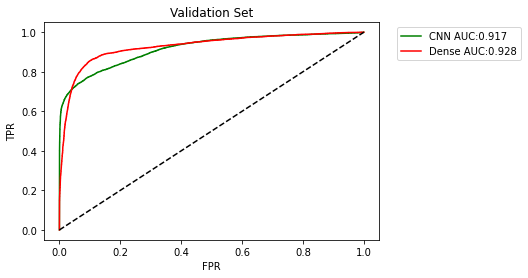

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_val, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_val, y_valid_preds_cnn)

fpr_valid_dense, tpr_valid_dense, t_valid_dense = roc_curve(y_val, y_valid_preds_dense)
auc_valid_dense = roc_auc_score(y_val, y_valid_preds_dense)

plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'g-', label = 'CNN AUC:%.3f'%auc_valid_cnn)
plt.plot(fpr_valid_dense, tpr_valid_dense, 'r-', label = 'Dense AUC:%.3f'%auc_valid_dense)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()

https://www.kaggle.com/gregoiredc/arrhythmia-on-ecg-classification-using-cnn

In [16]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint


def network():
    im_shape=(x_train_cnn.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(1, activation='sigmoid', name='main_output')(dense_end2)
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])
    
    return model


model = network()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      (None, 2160, 1)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2155, 64)          448       
_________________________________________________________________
batch_normalization_7 (Batch (None, 2155, 64)          256       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1078, 64)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1076, 64)          12352     
_________________________________________________________________
batch_normalization_8 (Batch (None, 1076, 64)          256       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 538, 64)           0   

In [17]:
# Define callbacks.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.fit(x_train_cnn, y_train,
            validation_data=(x_val_cnn, y_val),
            batch_size = 512, 
            epochs= 1000, 
            verbose = 1,
            callbacks=[early_stopping_cb])

Train on 60560 samples, validate on 23821 samples
Epoch 1/1000
60560/60560 [==============================] - 11s 181us/step - loss: 0.1209 - accuracy: 0.9560 - val_loss: 0.9287 - val_accuracy: 0.7022
Epoch 2/1000
60560/60560 [==============================] - 10s 171us/step - loss: 0.0253 - accuracy: 0.9916 - val_loss: 1.3901 - val_accuracy: 0.7022
Epoch 3/1000
60560/60560 [==============================] - 10s 170us/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 1.3389 - val_accuracy: 0.7336
Epoch 4/1000
60560/60560 [==============================] - 11s 174us/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.7679 - val_accuracy: 0.8187
Epoch 5/1000
60560/60560 [==============================] - 11s 175us/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.5492 - val_accuracy: 0.8889
Epoch 6/1000
60560/60560 [==============================] - 10s 172us/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.5283 - val_accuracy: 0.9018
Epoch 7/1000
60560/60560 [==================

In [19]:
y_train_preds_cnn = model.predict(x_train_cnn,verbose = 1)
y_valid_preds_cnn = model.predict(x_val_cnn,verbose = 1)
y_test_preds_cnn = model.predict(x_test_cnn,verbose = 1)

print('Train-----------')
print_report(y_train, y_train_preds_cnn, thresh)
print('Valid-----------')
print_report(y_val, y_valid_preds_cnn, thresh)
print('Test-----------')
print_report(y_test, y_test_preds_cnn, thresh)

24718/24718 [==============================] - 2s 98us/step
Train-----------
AUC:1.000
accuracy:1.000
recall:1.000
precision:0.999
specificity:1.000
prevalence:0.329
 
Valid-----------
AUC:0.962
accuracy:0.929
recall:0.840
precision:0.915
specificity:0.967
prevalence:0.298
 
Test-----------
AUC:0.787
accuracy:0.732
recall:0.557
precision:0.543
specificity:0.805
prevalence:0.294
 


(0.7868235610871905,
 0.7323003479245894,
 0.5573318632855567,
 0.5428916633105115,
 array([0.80500515]))

In [25]:
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Add, Flatten, Activation
from keras import backend as K
from keras.optimizers import Adam


def network2():
    """Implementation of https://arxiv.org/pdf/1805.00794.pdf"""
    
    n_obs, feature, depth = x_train_cnn.shape
    
    inp = Input(shape=(feature, depth))
    C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

    C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
    A11 = Activation("relu")(C11)
    C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
    S11 = Add()([C12, C])
    A12 = Activation("relu")(S11)
    M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


    C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
    A21 = Activation("relu")(C21)
    C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
    S21 = Add()([C22, M11])
    A22 = Activation("relu")(S11)
    M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


    C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
    A31 = Activation("relu")(C31)
    C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
    S31 = Add()([C32, M21])
    A32 = Activation("relu")(S31)
    M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


    C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
    A41 = Activation("relu")(C41)
    C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
    S41 = Add()([C42, M31])
    A42 = Activation("relu")(S41)
    M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


    C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
    A51 = Activation("relu")(C51)
    C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
    S51 = Add()([C52, M41])
    A52 = Activation("relu")(S51)
    M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

    F1 = Flatten()(M51)

    D1 = Dense(32)(F1)
    A6 = Activation("relu")(D1)
    D2 = Dense(32)(A6)
    D3 = Dense(1, activation='sigmoid')(D2)

    model = Model(inputs=inp, outputs=D3)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])
    
    return model

model = network2()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 2160, 1)      0                                            
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 2156, 32)     192         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 2156, 32)     5152        conv1d_25[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 2156, 32)     0           conv1d_26[0][0]                  
____________________________________________________________________________________________

In [26]:
# Define callbacks.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.fit(x_train_cnn, y_train,
            validation_data=(x_val_cnn, y_val),
            batch_size = 512, 
            epochs= 1000, 
            verbose = 1,
            callbacks=[early_stopping_cb])

Train on 60560 samples, validate on 23821 samples
Epoch 1/1000
60560/60560 [==============================] - 8s 136us/step - loss: 0.2901 - accuracy: 0.8790 - val_loss: 0.3360 - val_accuracy: 0.8868
Epoch 2/1000
60560/60560 [==============================] - 8s 128us/step - loss: 0.0536 - accuracy: 0.9828 - val_loss: 0.4116 - val_accuracy: 0.8987
Epoch 3/1000
60560/60560 [==============================] - 8s 128us/step - loss: 0.0356 - accuracy: 0.9882 - val_loss: 0.2442 - val_accuracy: 0.9325
Epoch 4/1000
60560/60560 [==============================] - 8s 125us/step - loss: 0.0253 - accuracy: 0.9915 - val_loss: 0.3933 - val_accuracy: 0.8719
Epoch 5/1000
60560/60560 [==============================] - 7s 123us/step - loss: 0.0189 - accuracy: 0.9937 - val_loss: 0.4137 - val_accuracy: 0.8862
Epoch 6/1000
60560/60560 [==============================] - 7s 124us/step - loss: 0.0180 - accuracy: 0.9940 - val_loss: 0.3123 - val_accuracy: 0.9300
Epoch 7/1000
60560/60560 [========================

In [27]:
y_train_preds_cnn = model.predict(x_train_cnn,verbose = 1)
y_valid_preds_cnn = model.predict(x_val_cnn,verbose = 1)
y_test_preds_cnn = model.predict(x_test_cnn,verbose = 1)

print('Train-----------')
print_report(y_train, y_train_preds_cnn, thresh)
print('Valid-----------')
print_report(y_val, y_valid_preds_cnn, thresh)
print('Test-----------')
print_report(y_test, y_test_preds_cnn, thresh)

24718/24718 [==============================] - 2s 74us/step
Train-----------
AUC:0.999
accuracy:0.991
recall:0.987
precision:0.987
specificity:0.994
prevalence:0.329
 
Valid-----------
AUC:0.957
accuracy:0.926
recall:0.867
precision:0.881
specificity:0.950
prevalence:0.298
 
Test-----------
AUC:0.874
accuracy:0.765
recall:0.792
precision:0.572
specificity:0.754
prevalence:0.294
 


(0.8741349975950299,
 0.7652318148717534,
 0.7923098125689085,
 0.5723245395719263,
 array([0.75398007]))